### Record

This version is used for comparing the tradeoff

** Prepare two datasets for training and extracting sensitive attributes separately
1. Traning dataset: get dummy variables for gender
2. Sensitive attribute: gender is set to object

roc_auc needs predicted probability
what is selection rate? do we need it?
which dataset to use for predictions?

----
Process
1. Data preparation
   * \# of rows: 131097, # of clicks: 6091
   * choose gender as sensitive attribute 
   * \# of rows: 131097 -> 88652
 
2. Choose baseline model
    * logitsic regression predicting all the obs to 0
        * tpr and fpr are 0 when c changes from 0.01 to 10000
    * label predictions of cart changes as ccp_alpha changes
        * use default threshold
        * choose ccp_alpha in terms of tpr and fpr
3. Evaluate fairness in the baseline model using testing data
4. Incorparate fairness constraint
    * default
    * a list of difference_bound
    * a list of ratio_bound
5. Tradeoff 
    * percentage change of auc
    * percentage change of F1-score
    * percentage change of tpr and fpr
----

Question

1. What metrics to use for choosing hyperparameters in cart and random forest?
2. Can we implement logistic regression in fairlearn?


In [94]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from fairlearn.metrics import MetricFrame
from sklearn.metrics import f1_score
# from sklearn.metrics import log_loss

# 1. Data preparation

#### Read undersampled data 

In [95]:
com_ad = pd.read_csv('/Users/huizhihan/Desktop/imp_to_click_final.csv')
com_ad.drop(['Unnamed: 0'], axis=1, inplace=True)
# com_ad.info()
com_ad.head()

,Timestamp_impressions,Log Type,User-Agent_impressions,Region ID_impressions,City ID,Ad Exchange,Ad Slot Width,Ad Slot Height,Ad Slot Visibility,Ad Slot Format,...,13678,13776,13800,13866,13874,14273,16593,16617,16661,16706
0,20130606000104828,1,Mozilla/4.0 (compatible; MSIE 8.0; Windows NT ...,216,219,1,336,280,2,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,20130606000104915,1,Mozilla/5.0 (Windows NT 5.1) AppleWebKit/537.1...,333,334,2,250,250,2,0,...,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
2,20130606000105049,1,Mozilla/5.0 (Linux; U; Android 4.1.1; zh-cn; M...,216,234,1,950,90,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,20130606000105216,1,Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.2...,79,79,2,728,90,2,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,20130606000105295,1,Mozilla/5.0 (Windows NT 5.1) AppleWebKit/537.2...,80,86,1,300,250,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [96]:
com_ad['gender'] = com_ad['10110'] + com_ad['10111']

In [97]:
com_ad = com_ad[com_ad['gender']==1]
com_ad.shape

(88652, 65)

In [98]:
com_ad = com_ad.drop(['gender','10111'],axis=1)
com_ad = com_ad.rename(columns={'10110':'is_male'})

#### fillna with 0 to indicate if a specific user profile exists excluding gender

In [99]:
# fillna with 0 to indicate if a specific user profile exists
com_ad[['10006','10024', '10031', '10048', '10052', '10057', '10059', '10063', '10067',
       '10074', '10075', '10076', '10077', '10079', '10083', '10093', '10102',
       '10684', '11092', '11278', '11379', '11423', '11512',
       '11576', '11632', '11680', '11724', '11944', '13042', '13403', '13496',
       '13678', '13776', '13800', '13866', '13874', '14273', '16593', '16617',
       '16661', '16706']] = com_ad[['10006','10024', '10031', '10048', '10052', '10057', '10059', '10063', '10067',
       '10074', '10075', '10076', '10077', '10079', '10083', '10093', '10102',
       '10684', '11092', '11278', '11379', '11423', '11512',
       '11576', '11632', '11680', '11724', '11944', '13042', '13403', '13496',
       '13678', '13776', '13800', '13866', '13874', '14273', '16593', '16617',
       '16661', '16706']].fillna(0)

com_ad[['10006','10024', '10031', '10048', '10052', '10057', '10059', '10063', '10067',
       '10074', '10075', '10076', '10077', '10079', '10083', '10093', '10102',
       '10684', '11092', '11278', '11379', '11423', '11512',
       '11576', '11632', '11680', '11724', '11944', '13042', '13403', '13496',
       '13678', '13776', '13800', '13866', '13874', '14273', '16593', '16617',
       '16661', '16706']]

,10006,10024,10031,10048,10052,10057,10059,10063,10067,10074,...,13678,13776,13800,13866,13874,14273,16593,16617,16661,16706
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
3,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
9,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131092,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
131093,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
131094,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
131095,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


#### Keep columns that are useful for model from imp to click

In [100]:
ad_imp = com_ad[['Timestamp_impressions', 'Log Type', 
       'Region ID_impressions', 'City ID', 'Ad Exchange', 'Ad Slot Width',
       'Ad Slot Height', 'Ad Slot Visibility', 'Ad Slot Format',
       'Ad Slot Floor Price', 'Bidding Price', 'Paying Price', 'Advertiser ID',
       'has click',
       '10006', '10024', '10031', '10048', '10052', '10057', '10059', '10063',
       '10067', '10074', '10075', '10076', '10077', '10079', '10083', '10093',
       '10102', 'is_male', '10684', '11092', '11278', '11379', '11423',
       '11512', '11576', '11632', '11680', '11724', '11944', '13042', '13403',
       '13496', '13678', '13776', '13800', '13866', '13874', '14273', '16593',
       '16617', '16661', '16706']]

ad_imp.shape

(88652, 56)

#### Remove the city id since it's highly related to region id

<AxesSubplot:>

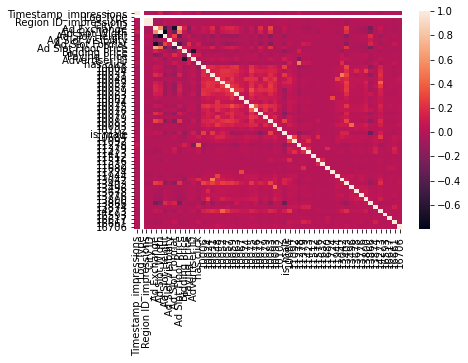

In [101]:
corr = ad_imp.corr()
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns)

In [102]:
# print top two correlations for each column 
for i in ad_imp.columns:
    print(corr[i].nlargest(2))

Timestamp_impressions    1.000000
Ad Slot Width            0.134777
Name: Timestamp_impressions, dtype: float64
Series([], Name: Log Type, dtype: float64)
Region ID_impressions    1.000000
City ID                  0.995189
Name: Region ID_impressions, dtype: float64
City ID                  1.000000
Region ID_impressions    0.995189
Name: City ID, dtype: float64
Ad Exchange            1.000000
Ad Slot Floor Price    0.685765
Name: Ad Exchange, dtype: float64
Ad Slot Width    1.000000
Ad Exchange      0.582331
Name: Ad Slot Width, dtype: float64
Ad Slot Height    1.000000
Ad Slot Format    0.282354
Name: Ad Slot Height, dtype: float64
Ad Slot Visibility    1.000000
Ad Slot Format        0.098739
Name: Ad Slot Visibility, dtype: float64
Ad Slot Format    1.000000
Ad Slot Height    0.282354
Name: Ad Slot Format, dtype: float64
Ad Slot Floor Price    1.000000
Ad Exchange            0.685765
Name: Ad Slot Floor Price, dtype: float64
Bidding Price    1.000000
Ad Exchange      0.148539
Name: 

In [103]:
ad_imp = ad_imp.drop(['City ID'], axis=1)
ad_imp.shape

(88652, 55)

In [104]:
ad_imp_summary = ad_imp.describe()
ad_imp_summary

,Timestamp_impressions,Log Type,Region ID_impressions,Ad Exchange,Ad Slot Width,Ad Slot Height,Ad Slot Visibility,Ad Slot Format,Ad Slot Floor Price,Bidding Price,...,13678,13776,13800,13866,13874,14273,16593,16617,16661,16706
count,8.865200e+04,88652.0,88652.000000,88652.000000,88652.000000,88652.000000,88652.000000,88652.000000,88652.000000,88652.000000,...,88652.000000,88652.000000,88652.000000,88652.000000,88652.000000,88652.000000,88652.000000,88652.000000,88652.000000,88652.000000
mean,2.013061e+16,1.0,143.652033,2.074753,596.181812,192.394193,3.098091,0.364391,27.381920,268.064680,...,0.022932,0.061014,0.123663,0.236836,0.001072,0.129642,0.001286,0.001974,0.003305,0.002008
std,1.984319e+09,0.0,102.245699,0.839593,328.123548,132.482990,23.979628,0.681330,34.636356,30.345306,...,0.149689,0.239357,0.329199,0.425143,0.032718,0.335911,0.035837,0.044386,0.057395,0.044764
min,2.013061e+16,1.0,0.000000,1.000000,120.000000,60.000000,0.000000,0.000000,0.000000,227.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.013061e+16,1.0,65.000000,1.000000,300.000000,90.000000,0.000000,0.000000,0.000000,238.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.013061e+16,1.0,134.000000,2.000000,468.000000,90.000000,0.000000,0.000000,5.000000,254.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2.013061e+16,1.0,216.000000,3.000000,1000.000000,250.000000,2.000000,1.000000,50.000000,300.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2.013061e+16,1.0,395.000000,3.000000,1000.000000,600.000000,255.000000,5.000000,295.000000,300.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [105]:
# filter constant feature [std = 0]
ad_imp_summary.loc['std'][ad_imp_summary.loc['std'] == 0]

Log Type    0.0
Name: std, dtype: float64

In [106]:
# drop feature Log Type because it's a constant
ad_imp.drop(['Log Type'], axis=1, inplace=True)
ad_imp.shape

(88652, 54)

#### filter data with impression == 1

In [107]:
# filter has impression == 1 to get the suitable dataset
ad_imp2clk = ad_imp.copy()

#### Convert some numerical variables to categorical variables

* Ad Exchange: the source of replacement of this as

* Ad Slot Visibility: relative location to the fold

* Ad Slot Format: popup / fixed

* Advertiser ID: advertiser field

* Region ID

NOT include in the dataset

** Ad Slot ID: the location of current id

** Creative ID:

In [108]:
# set ad exchange as object to get dummy variables
ad_imp2clk['Ad Exchange'] = ad_imp2clk['Ad Exchange'].astype('object')
# set ad slot visibility as object to get dummy variables
ad_imp2clk['Ad Slot Visibility'] = ad_imp2clk['Ad Slot Visibility'].astype('object')
# set ad slot format as object to get dummy variables
ad_imp2clk['Ad Slot Format'] = ad_imp2clk['Ad Slot Format'].astype('object')
# set advertiser id as object to get dummy variables
ad_imp2clk['Advertiser ID'] = ad_imp2clk['Advertiser ID'].astype('object')
# set region id as object to get dummy variables
ad_imp2clk['Region ID_impressions'] = ad_imp2clk['Region ID_impressions'].astype('object')
# set is_male as object to get dummy variables
ad_imp2clk['is_male'] = ad_imp2clk['is_male'].astype('object')

#### Training and testing data for fairlearn constraint

* Only used for extracting sensitive attribute

In [109]:
# use earlier five days as training data
imp2clk_train = ad_imp2clk[ad_imp2clk['Timestamp_impressions']<20130611000000000]
print(imp2clk_train.shape)
# use the following two days as testing data
imp2clk_test = ad_imp2clk[ad_imp2clk['Timestamp_impressions']>=20130611000000000]
print(imp2clk_test.shape)

(64798, 54)
(23854, 54)


In [110]:
# training set without dummy variables
X1_train = imp2clk_train.drop('has click',axis=1)
y1_train = imp2clk_train['has click']

In [111]:
# testing set without dummy variables
X1_test = imp2clk_test.drop('has click',axis=1)
y1_test = imp2clk_test['has click']

In [112]:
X1_train.columns

Index(['Timestamp_impressions', 'Region ID_impressions', 'Ad Exchange',
       'Ad Slot Width', 'Ad Slot Height', 'Ad Slot Visibility',
       'Ad Slot Format', 'Ad Slot Floor Price', 'Bidding Price',
       'Paying Price', 'Advertiser ID', '10006', '10024', '10031', '10048',
       '10052', '10057', '10059', '10063', '10067', '10074', '10075', '10076',
       '10077', '10079', '10083', '10093', '10102', 'is_male', '10684',
       '11092', '11278', '11379', '11423', '11512', '11576', '11632', '11680',
       '11724', '11944', '13042', '13403', '13496', '13678', '13776', '13800',
       '13866', '13874', '14273', '16593', '16617', '16661', '16706'],
      dtype='object')

#### Prepare training and testing dataset based on encoded impression dataset

* Use encoded version in the modeling

In [113]:
# convert region id into dummy variables
ad_imp2clk_enc = pd.get_dummies(ad_imp2clk, columns = ['Ad Exchange', 'Ad Slot Visibility','Ad Slot Format','Region ID_impressions','Advertiser ID','is_male'])
ad_imp2clk_enc.head()

,Timestamp_impressions,Ad Slot Width,Ad Slot Height,Ad Slot Floor Price,Bidding Price,Paying Price,has click,10006,10024,10031,...,Region ID_impressions_393,Region ID_impressions_394,Region ID_impressions_395,Advertiser ID_1458,Advertiser ID_3358,Advertiser ID_3386,Advertiser ID_3427,Advertiser ID_3476,is_male_0.0,is_male_1.0
0,20130606000104828,336,280,0,300,51,0,1.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,1
1,20130606000104915,250,250,23,249,68,0,1.0,1.0,1.0,...,0,0,0,0,0,0,0,1,0,1
3,20130606000105216,728,90,5,238,45,0,1.0,1.0,0.0,...,0,0,0,0,0,0,1,0,0,1
9,20130606000105938,728,90,5,249,45,0,1.0,0.0,1.0,...,0,0,0,0,0,0,0,1,0,1
12,20130606000106153,950,90,0,227,109,0,0.0,0.0,0.0,...,0,0,0,0,1,0,0,0,1,0


In [114]:
# use earlier five days as training data 
imp2clk_train_enc = ad_imp2clk_enc[ad_imp2clk_enc['Timestamp_impressions']<20130611000000000]
# use the following two days as testing data
imp2clk_test_enc = ad_imp2clk_enc[ad_imp2clk_enc['Timestamp_impressions'] >= 20130611000000000]

In [115]:
# baseline model
train_clk = np.sum(imp2clk_train_enc['has click']==1)
train_not_clk = np.sum(imp2clk_train_enc['has click']==0)

print(pd.Series({'0': train_not_clk, '1': train_clk}))

# baseline model should predict not click for all observations in the test set

0    60665
1     4133
dtype: int64


In [116]:
# baseline model prediction probability
baseline_clk_prob = train_clk / (train_clk + train_not_clk)
baseline_clk_prob

0.06378283280348158

In [117]:
# filter all constant features in the impression training set
imp2clk_train_enc_summary = imp2clk_train_enc.describe()
imp2clk_train_enc_summary.loc['std'][imp2clk_train_enc_summary.loc['std'] == 0]

Series([], Name: std, dtype: float64)

In [118]:
# encoded training set
X1_train_enc = imp2clk_train_enc.drop('has click', axis=1)
y1_train_enc = imp2clk_train_enc['has click']

In [119]:
# encoded testing set
X1_test_enc = imp2clk_test_enc.drop('has click', axis=1)
y1_test_enc = imp2clk_test_enc['has click']

In [120]:
X1_train_enc

,Timestamp_impressions,Ad Slot Width,Ad Slot Height,Ad Slot Floor Price,Bidding Price,Paying Price,10006,10024,10031,10048,...,Region ID_impressions_393,Region ID_impressions_394,Region ID_impressions_395,Advertiser ID_1458,Advertiser ID_3358,Advertiser ID_3386,Advertiser ID_3427,Advertiser ID_3476,is_male_0.0,is_male_1.0
0,20130606000104828,336,280,0,300,51,1.0,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,1
1,20130606000104915,250,250,23,249,68,1.0,1.0,1.0,0.0,...,0,0,0,0,0,0,0,1,0,1
3,20130606000105216,728,90,5,238,45,1.0,1.0,0.0,0.0,...,0,0,0,0,0,0,1,0,0,1
9,20130606000105938,728,90,5,249,45,1.0,0.0,1.0,1.0,...,0,0,0,0,0,0,0,1,0,1
12,20130606000106153,950,90,0,227,109,0.0,0.0,0.0,0.0,...,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94329,20130610234010261,1000,90,50,241,55,0.0,0.0,0.0,0.0,...,0,0,0,0,1,0,0,0,1,0
94330,20130610234010305,1000,90,70,241,77,0.0,0.0,0.0,0.0,...,0,0,0,0,1,0,0,0,0,1
94331,20130610234012418,1000,90,80,241,88,1.0,1.0,1.0,1.0,...,0,0,0,0,1,0,0,0,0,1
94333,20130610234013860,960,90,10,241,11,1.0,0.0,1.0,0.0,...,0,0,0,0,1,0,0,0,0,1


In [121]:
X1_train

,Timestamp_impressions,Region ID_impressions,Ad Exchange,Ad Slot Width,Ad Slot Height,Ad Slot Visibility,Ad Slot Format,Ad Slot Floor Price,Bidding Price,Paying Price,...,13678,13776,13800,13866,13874,14273,16593,16617,16661,16706
0,20130606000104828,216,1,336,280,2,1,0,300,51,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,20130606000104915,333,2,250,250,2,0,23,249,68,...,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
3,20130606000105216,79,2,728,90,2,0,5,238,45,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
9,20130606000105938,1,2,728,90,2,0,5,249,45,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
12,20130606000106153,124,1,950,90,255,1,0,227,109,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94329,20130610234010261,298,3,1000,90,0,0,50,241,55,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
94330,20130610234010305,106,3,1000,90,0,0,70,241,77,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
94331,20130610234012418,238,3,1000,90,0,0,80,241,88,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
94333,20130610234013860,183,3,960,90,0,0,10,241,11,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# 2. Model

### 2.1 Logistic Regression

#### default

In [ ]:
# logistic regression model from linear_model
from sklearn import linear_model
logreg2 = linear_model.LogisticRegression(max_iter=500000,solver='saga')
logreg2 = logreg2.fit(X1_train_enc,y1_train_enc)

In [ ]:
# predict the label/class
y1_logreg_label= logreg2.predict(X1_test_enc)

In [ ]:
from sklearn.metrics import confusion_matrix

cm_logreg = confusion_matrix(y1_test_enc, y1_logreg_label)
cm_logreg
# tn, fp, fn, tp

In [ ]:
# true positive rate
tpr_lr = cm_logreg.ravel()[3] / (cm_logreg.ravel()[2] + cm_logreg.ravel()[3])
print('tpr for logistic regression is:', tpr_lr )
# false positive rate
fpr_lr = cm_logreg.ravel()[1] / (cm_logreg.ravel()[0] + cm_logreg.ravel()[1])
print('fpr for logistic regression is:', fpr_lr)

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y1_test_enc, y1_logreg_label)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.title('ROC Curve', fontsize=18)
plt.xlabel('FPR', fontsize=16)
plt.ylabel('TPR', fontsize=16)
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
plt.plot(fpr, tpr, lw=3, label='Logistic Regression (area = {:0.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
plt.legend(loc='lower right', fontsize=14)
plt.show()

#### cross-validation choosing c

In [ ]:
from sklearn.metrics import confusion_matrix

def tpr(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tpr = cm.ravel()[3] / (cm.ravel()[2] + cm.ravel()[3])
    return tpr

def fpr(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    fpr = cm.ravel()[1] / (cm.ravel()[0] + cm.ravel()[1])
    return fpr

In [ ]:
y1_train_enc

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.metrics import make_scorer

grid_values = { 'C': [10000,100,10,1,0.1,0.01],
                'max_iter': [50000000],
                'solver': ['saga'],
                'penalty': ['l2']
}

logreg = linear_model.LogisticRegression()
logreg_cv = GridSearchCV(logreg, param_grid=grid_values, 
                         scoring='roc_auc',cv=5)
logreg_cv.fit(X1_train_enc, y1_train_enc)

In [ ]:
roc_auc_lr = logreg_cv.cv_results_['mean_test_score']
c = logreg_cv.cv_results_['param_C'].data

pd.DataFrame({'C': c, 'ROC_AUC':roc_auc_lr})

### 2.2 CART

#### max_depth=30

In [ ]:
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
import time

grid_values = {'ccp_alpha': np.linspace(0, 0.1, 201),
               'min_samples_leaf': [5],
               'min_samples_split': [20],
               'max_depth': [30],
#                'class_weight' : [{0: 1, 1: 20}],
               'random_state': [88]} 

tic = time.time()

dtc2 = DecisionTreeClassifier()
dtc_cv2_logloss = GridSearchCV(dtc2, param_grid = grid_values,
                               scoring='roc_auc',
                               cv=5, verbose=2, refit=False) 
dtc_cv2_logloss.fit(X1_train_enc, y1_train_enc)

toc = time.time()
print('time:', round(toc-tic, 2),'s')

In [ ]:
roc_auc_cart = dtc_cv2_logloss.cv_results_['mean_test_score']# what sklearn calls mean_test_score is the holdout set, i.e. the validation set.
ccp = dtc_cv2_logloss.cv_results_['param_ccp_alpha'].data

pd.DataFrame({'ccp alpha' : ccp, 'roc_auc': roc_auc_cart}).head(30)

In [ ]:
plt.figure(figsize=(8, 6))
plt.xlabel('ccp_alpha', fontsize=16)
plt.ylabel('roc_auc', fontsize=16)
plt.scatter(ccp, roc_auc_cart, s=10)
# plt.plot(ccp, fpr_cart, linewidth=3)
plt.grid(True, which='both')
plt.show()

#### cart1 with ccp_alpha=0.0

In [ ]:
dtc1 = DecisionTreeClassifier(ccp_alpha=0.0, min_samples_leaf=5, min_samples_split=20, max_depth=30, random_state=88)
dtc1.fit(X1_train_enc, y1_train_enc)
y1_cart1_label = dtc1.predict(X1_test_enc)

In [ ]:
def tpr(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tpr = cm.ravel()[3] / (cm.ravel()[2] + cm.ravel()[3])
    
    return tpr

def fpr(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    fpr = cm.ravel()[1] / (cm.ravel()[0] + cm.ravel()[1])
    
    return fpr

In [ ]:
tpr_dtc = tpr(y1_test_enc, y1_cart1_label)
print('tpr for cart is: ', tpr_dtc)
fpr_dtc = fpr(y1_test_enc, y1_cart1_label)
print('fpr for cart is: ', fpr_dtc)

### 2.3 Random Forest

#### CV of Random Forest parameters

In [ ]:
# find suitable parameters
# other parameters are given in 242 lab
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import time

grid_values = {'max_features': np.linspace(1,98,98, dtype='int32'),
               'min_samples_leaf': [5],
               'max_depth':[30],
               'n_estimators': [500],
               'random_state': [88]} 

tic = time.time()

rf2 = RandomForestClassifier() 
rf_cv = GridSearchCV(rf2, param_grid=grid_values, 
                     scoring='roc_auc', 
                     cv=5, verbose=2, refit=False)
rf_cv.fit(X1_train_enc, y1_train_enc)

toc = time.time()

print('time:', round(toc-tic, 2),'s')

#### Feature Importance for Random Forest

In [ ]:
# importance score 
importance_score = pd.DataFrame({'Feature' : X1_train_enc.columns, 
              'Importance score': 100*rf_cv.best_estimator_.feature_importances_}).round(1)

In [ ]:
# top 50 importance score
top50_is = importance_score.sort_values('Importance score',ascending=False).head(50)
top50_is

## 3. Fairness constraint

### 3.1 Sensitive attribute

In [29]:
# Sensitive attribute 10110 used for training
gender_train = X1_train['is_male']

In [30]:
# sensitive attribute used for testing
gender_test = X1_test['is_male']

### 3.2 CART

#### 3.2.1 Evaluating fairness

In [ ]:
classifier_dtc = DecisionTreeClassifier(ccp_alpha=0.0, min_samples_leaf=5, min_samples_split=20, max_depth=30, random_state=88)

In [34]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score

def tpr(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tpr = cm.ravel()[3] / (cm.ravel()[2] + cm.ravel()[3])
    return tpr

def fpr(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    fpr = cm.ravel()[1] / (cm.ravel()[0] + cm.ravel()[1])
    return fpr

In [ ]:
classifier_dtc_base = DecisionTreeClassifier(ccp_alpha=0.0, min_samples_leaf=5, min_samples_split=20, max_depth=30, random_state=88)
classifier_dtc_base.fit(X1_train_enc, y1_train_enc)
y1_pred_dtc = classifier_dtc_base.predict(X1_test_enc)

#### TPR

In [ ]:
tpr_dtc_evl = MetricFrame(tpr, y1_test_enc, y1_pred_dtc, sensitive_features=gender_test)
print(tpr_dtc_evl.overall)

In [ ]:
print(tpr_dtc_evl.by_group)

In [ ]:
tpr_dtc = tpr(y1_test_enc, y1_pred_dtc)
tpr_dtc

#### FPR

In [ ]:
fpr_dtc_evl = MetricFrame(fpr, y1_test_enc, y1_pred_dtc, sensitive_features=gender_test)
print('evl fpr of CART is: ', fpr_dtc_evl.overall)

In [ ]:
print('evl fpr of CART by group is:\n', fpr_dtc_evl.by_group)

In [ ]:
fpr_dtc = fpr(y1_test_enc, y1_pred_dtc)
fpr_dtc

#### F1-score

In [ ]:
# from sklearn.metrics import f1_score
f1_dtc_evl = MetricFrame(f1_score, y1_test_enc, y1_pred_dtc, sensitive_features=gender_test)
f1_dtc_evl.overall

In [ ]:
f1_dtc_evl.by_group

In [ ]:
f1_dtc = f1_score(y1_test_enc, y1_pred_dtc)
f1_dtc

#### 3.2.2 Mitigated model

In [ ]:
# a list of difference_bound
bound_list = list(np.linspace(0, 0.05, 50))
# tpr
tpr_dtc_list = [np.nan]*len(bound_list)
# fpr
fpr_dtc_list = [np.nan]*len(bound_list)
# F1-score
f1_dtc_list = [np.nan]*len(bound_list)

In [ ]:
from fairlearn.reductions import ExponentiatedGradient, DemographicParity
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
import time


def tpr(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tpr = cm.ravel()[3] / (cm.ravel()[2] + cm.ravel()[3])
    return tpr

def fpr(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    fpr = cm.ravel()[1] / (cm.ravel()[0] + cm.ravel()[1])
    return fpr

# baseline
classifier_dtc = DecisionTreeClassifier(ccp_alpha=0.0, min_samples_leaf=5, 
                                            min_samples_split=20, max_depth=30, random_state=88)

tic = time.time()

for i in range(len(bound_list)):
    sample_i = bound_list[i]
    # mitigating disparity
    np.random.seed(0)
    constraint = DemographicParity(difference_bound=sample_i)
    mitigator_dtc = ExponentiatedGradient(classifier_dtc, constraint)
    mitigator_dtc.fit(X1_train_enc, y1_train_enc, sensitive_features=gender_train)
    y1_pred_dtc = mitigator_dtc.predict(X1_test_enc)
    
    # evaluating fairness in terms of f1-score
    f1_mitigated_i = MetricFrame(f1_score, y1_test_enc, y1_pred_dtc, sensitive_features=gender_test)
    f1_dtc_list[i] = f1_mitigated_i.overall
    
    # evaluating fairness in terms of tpr
    tpr_dtc_mitigated_i = MetricFrame(tpr, y1_test_enc, y1_pred_dtc, sensitive_features=gender_test)
    tpr_dtc_list[i] = tpr_dtc_mitigated_i.overall
    
    # evaluating fairness in terms of fpr
    fpr_dtc_mitigated_i = MetricFrame(fpr, y1_test_enc, y1_pred_dtc, sensitive_features=gender_test)
    fpr_dtc_list[i] = fpr_dtc_mitigated_i.overall
    
toc = time.time()

print('time:', round(toc-tic,2), 's')

In [ ]:
comparison_dtc = pd.DataFrame({'difference_bound':bound_list, 
#                                'decrease%_auc': auc_delta_list,
                               'f1': f1_dtc_list,
                               'tpr': tpr_dtc_list,
                               'fpr': fpr_dtc_list})

In [ ]:
comparison_dtc.head(10)

In [ ]:
plt.figure(figsize=(8,6))
plt.title('Decision Tree Classifier (F1-score)', fontsize=16)
plt.xlabel('value of difference_bound', fontsize=16)
plt.ylabel('f1-score', fontsize=16)
plt.ylim([0.76, 0.82])
plt.axhline(y=f1_dtc_evl.overall, color='r', linestyle='--', label='baseline')
plt.scatter(x=comparison_dtc['difference_bound'], y=comparison_dtc['f1'], label='mitigated model')
plt.legend()

In [ ]:
plt.figure(figsize=(8,6))
plt.title('Decision Tree Classifier (TPR)', fontsize=16)
plt.xlabel('value of difference_bound', fontsize=16)
plt.ylabel('tpr', fontsize=16)
plt.ylim([0.7, 0.76])
plt.axhline(y=tpr_dtc_evl.overall, color='r', linestyle='--', label='baseline')
plt.scatter(x=comparison_dtc['difference_bound'], y=comparison_dtc['tpr'],label='mitigated model')
plt.legend()

In [ ]:
plt.figure(figsize=(8,6))
plt.title('Decision Tree Classifier (FPR)', fontsize=16)
plt.xlabel('value of difference_bound', fontsize=16)
plt.ylabel('fpr', fontsize=16)
plt.ylim([0.005,0.016])
plt.axhline(y=fpr_dtc_evl.overall, color='r', linestyle='--', label='baseline')
plt.scatter(x=comparison_dtc['difference_bound'], y=comparison_dtc['fpr'], label='mitigated model')
plt.legend()

### 3.3 ***Random forest

#### 3.3.1 Evaluating fairness

In [31]:
classifier_rf = RandomForestClassifier(max_features=9, min_samples_leaf=5, max_depth=30, n_estimators=500, random_state=88)

In [32]:
classifier_rf.fit(X1_train_enc, y1_train_enc)
y1_pred_rf = classifier_rf.predict(X1_test_enc)

#### TPR

In [35]:
tpr_rf = tpr(y1_test_enc, y1_pred_rf)
tpr_rf

0.6317671092951992

In [36]:
tpr_rf_evl = MetricFrame(tpr, y1_test_enc, y1_pred_rf, sensitive_features=gender_test)
print(tpr_rf_evl.overall)

0.6317671092951992


In [37]:
print(tpr_rf_evl.by_group)

is_male
0.0     0.74152
1.0    0.546691
Name: tpr, dtype: object


#### FPR

In [49]:
fpr_rf = fpr(y1_test_enc, y1_pred_rf)
fpr_rf

0.0012787723785166241

In [50]:
fpr_rf_evl = MetricFrame(fpr, y1_test_enc, y1_pred_rf, sensitive_features=gender_test)
print(fpr_rf_evl.overall)

0.0012787723785166241


In [51]:
print(fpr_rf_evl.by_group)

is_male
0.0    0.001755
1.0    0.001035
Name: fpr, dtype: object


#### F1-score

In [52]:
f1_rf = f1_score(y1_test_enc, y1_pred_rf)
f1_rf

0.7676078188023581

In [53]:
f1_rf_evl = MetricFrame(f1_score, y1_test_enc, y1_pred_rf, sensitive_features=gender_test)
print(f1_rf_evl.overall)

0.7676078188023581


In [54]:
print(f1_rf_evl.by_group)

is_male
0.0    0.844208
1.0    0.700755
Name: f1_score, dtype: object


#### 3.3.2 Mitigated model

In [55]:
# a list of difference_bound
bound_list_rf = list(np.linspace(0, 0.04, 40))
# relative change of tpr
tpr_rf_list = [np.nan]*len(bound_list_rf)
# relative change of fpr
fpr_rf_list = [np.nan]*len(bound_list_rf)
# relative change of f1-score
f1_rf_list = [np.nan]*len(bound_list_rf)

In [56]:
from fairlearn.reductions import ExponentiatedGradient, DemographicParity
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
import time


def tpr(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tpr = cm.ravel()[3] / (cm.ravel()[2] + cm.ravel()[3])
    return tpr

def fpr(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    fpr = cm.ravel()[1] / (cm.ravel()[0] + cm.ravel()[1])
    return fpr

# baseline
classifier_rf = RandomForestClassifier(max_features=9, min_samples_leaf=5, max_depth=30, n_estimators=500, random_state=88)

tic = time.time()

for i in range(len(bound_list_rf)):
    sample_i = bound_list_rf[i]
    # mitigating disparity
    np.random.seed(0)
    constraint = DemographicParity(difference_bound=sample_i)
    mitigator_rf = ExponentiatedGradient(classifier_rf, constraint)
    mitigator_rf.fit(X1_train_enc, y1_train_enc, sensitive_features=gender_train)
    y1_pred_rf = mitigator_rf.predict(X1_test_enc)
    
#     # evaluating fairness in terms of auc
#     auc_mitigated_i = MetricFrame(roc_auc_score, y1_test_enc, y1_pred_rf, sensitive_features=gender_test)
#     relative_decrease_auc_i = (auc_rf - auc_mitigated_i.overall) / auc_rf
#     auc_delta_list[i] = relative_decrease_auc_i
    
    # evaluating fairness in terms of f1-score
    f1_rf_mitigated_i = MetricFrame(f1_score, y1_test_enc, y1_pred_rf, sensitive_features=gender_test)
#     relative_decrease_f1_i = (f1_rf - f1_mitigated_i.overall) / f1_rf
    f1_rf_list[i] = f1_rf_mitigated_i.overall
    
    # evaluating fairness in terms of tpr
    tpr_rf_mitigated_i = MetricFrame(tpr, y1_test_enc, y1_pred_rf, sensitive_features=gender_test)
#     relative_decrease_tpr_i = (tpr_rf - tpr_rf_mitigated_i.overall) / tpr_rf
    tpr_rf_list[i] = tpr_rf_mitigated_i.overall
    
    # evaluating fairness in terms of fpr
    fpr_rf_mitigated_i = MetricFrame(fpr, y1_test_enc, y1_pred_rf, sensitive_features=gender_test)
#     relative_decrease_fpr_i = (fpr_rf - fpr_rf_mitigated_i.overall) / fpr_rf
    fpr_rf_list[i] = fpr_rf_mitigated_i.overall
    
toc = time.time()

print('time:', round(toc-tic,2), 's')

time: 43227.04 s


In [57]:
comparison_rf = pd.DataFrame({'difference_bound':bound_list_rf, 
                               'f1': f1_rf_list,
                               'tpr': tpr_rf_list,
                               'fpr': fpr_rf_list})

In [58]:
comparison_rf.head(10)

,difference_bound,f1,tpr,fpr
0,0.000000,0.694240,0.578652,0.007901
1,0.001042,0.693588,0.574566,0.007353
2,0.002083,0.699878,0.588355,0.008312
3,0.003125,0.701884,0.580184,0.006531
4,0.004167,0.707636,0.593973,0.007581
5,0.005208,0.714503,0.600102,0.007125
6,0.006250,0.718731,0.589888,0.004613
7,0.007292,0.718387,0.600613,0.006394
8,0.008333,0.724493,0.592952,0.003928
9,0.009375,0.727049,0.604699,0.005252


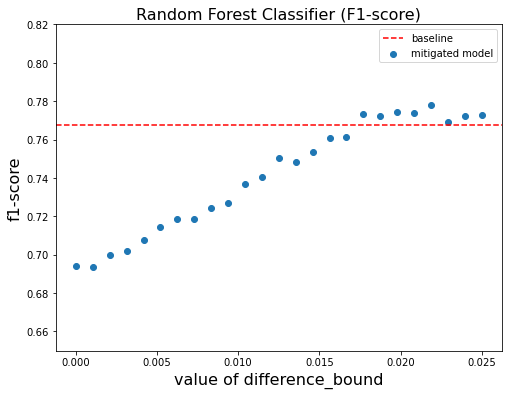

In [88]:
plt.figure(figsize=(8,6))
plt.title('Random Forest Classifier (F1-score)', fontsize=16)
plt.xlabel('value of difference_bound', fontsize=16)
plt.ylabel('f1-score', fontsize=16)
plt.ylim([0.65, 0.82])
plt.axhline(y=f1_rf_evl.overall, color='r', linestyle='--', label='baseline')
plt.scatter(x=comparison_rf['difference_bound'], y=comparison_rf['f1'], label='mitigated model')
plt.legend()

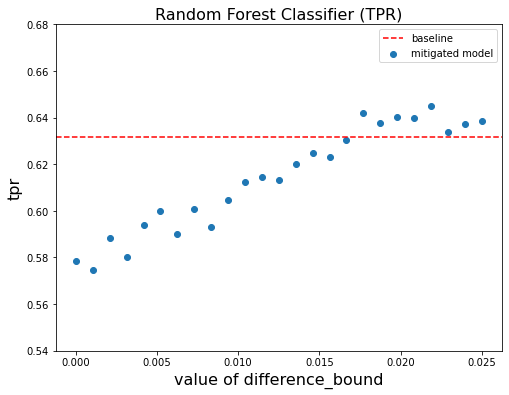

In [87]:
plt.figure(figsize=(8,6))
plt.title('Random Forest Classifier (TPR)', fontsize=16)
plt.xlabel('value of difference_bound', fontsize=16)
plt.ylabel('tpr', fontsize=16)
plt.ylim([0.54, 0.68])
plt.axhline(y=tpr_rf_evl.overall, color='r', linestyle='--', label='baseline')
plt.scatter(x=comparison_rf['difference_bound'], y=comparison_rf['tpr'], label='mitigated model')
plt.legend()

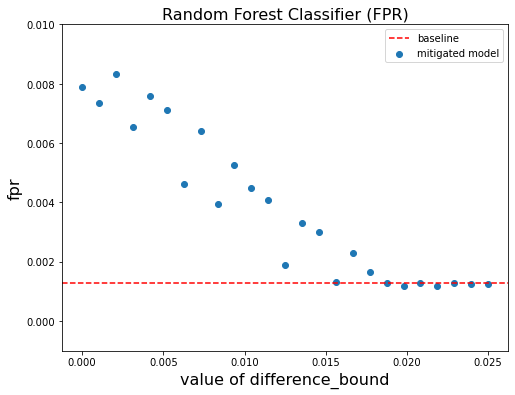

In [92]:
plt.figure(figsize=(8,6))
plt.title('Random Forest Classifier (FPR)', fontsize=16)
plt.xlabel('value of difference_bound', fontsize=16)
plt.ylabel('fpr', fontsize=16)
plt.ylim([-0.001,0.01])
plt.axhline(y=fpr_rf_evl.overall, color='r', linestyle='--', label='baseline')
plt.scatter(x=comparison_rf['difference_bound'], y=comparison_rf['fpr'], label='mitigated model')
plt.legend()

## Appendix: Visualization

In [ ]:
# prepare for visualization
ad_imp2clk_Vis = ad_imp2clk.copy()

#### distribution of `Paying Price` based on `has click`

In [ ]:
# mapping the label name 
has_click = {0 : 'not click', 1 :'click'}

In [ ]:
ad_imp2clk_Vis['has click'] = ad_imp2clk_Vis['has click'].map(has_click)

In [ ]:
ad_imp2clk_Vis['has click'].head()

In [ ]:
import seaborn as sns
sns.set_theme(style='whitegrid')
ax = sns.boxplot(x='has click', y='Paying Price', data=ad_imp2clk_Vis)

#### user profile `11278` based on `has click`

In [ ]:
ad_imp2clk_Vis.groupby('has click').sum()['11278']

In [ ]:
ad_imp_NoClk = ad_imp2clk[ad_imp2clk['has click'] == 0]

In [ ]:
# click
ad_clk['11278'].value_counts()

In [ ]:
# not click
ad_imp_NoClk['11278'].value_counts()

In [ ]:
# 11278: In-market/clothing、shoes&bags
from IPython.display import Image
Image(filename='/Users/jzw/Downloads/0 CAPSTONE/ipinyou.contest.dataset/data_exploration/11278.png') 

#### `Paying price` and  `has click`

In [ ]:
fig, ax = plt.subplots()
groups = ad_imp2clk.groupby('Region ID_clicks')
ax.margins(0.05)
for name, group in groups:
    ax.plot(group['Paying Price'], group['has click'], marker='o', linestyle='', ms=12, label=name)
# ax.legend(loc='best')
plt.ylim([-0.01, 1.04])
plt.xlabel('Paying Price')
plt.ylabel('click label')

#### `Timestamp` and `has click` 

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(ad_imp2clk['Timestamp_imp'], ad_imp2clk['has click'])
plt.ylim([-0.01, 1.00])
plt.xlabel('Timestamp')
plt.ylabel('click label')

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

x = [4,8,12,16,1,4,9,16]
y = [1,4,9,16,4,8,12,3]
label = [0,1,2,3,0,1,2,3]
colors = ['red','green','blue','purple']

fig = plt.figure(figsize=(8,8))
plt.scatter(x, y, c=label, cmap=matplotlib.colors.ListedColormap(colors))

cb = plt.colorbar()
loc = np.arange(0,max(label),max(label)/float(len(colors)))
cb.set_ticks(loc)
cb.set_ticklabels(colors)
